<a href="https://colab.research.google.com/github/ancestor9/2025_Fall_AI-Model-Operations-MLOps/blob/main/week04/Introduction_to_Fast_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import joblib
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# 1. 가상의 회귀 데이터 생성
X, y = make_regression(
    n_samples=50,
    n_features=1,
    noise=10,
    random_state=42
)

# 2. 선형 회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X, y)

# 3. 모델 저장
joblib.dump(model, 'regression_model.pkl')
print("모델이 'regression_model.pkl' 파일로 저장되었습니다.")

모델이 'regression_model.pkl' 파일로 저장되었습니다.


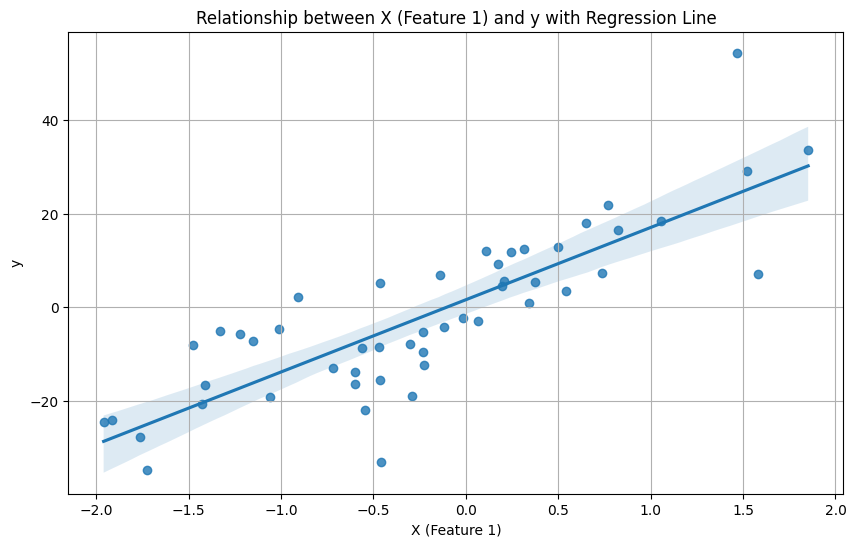

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 4. 데이터 시각화 (X의 첫 번째 특성과 y의 관계)
plt.figure(figsize=(10, 6))
sns.regplot(x=X[:, 0], y=y) # Add regression line
plt.title('Relationship between X (Feature 1) and y with Regression Line')
plt.xlabel('X (Feature 1)')
plt.ylabel('y')
plt.grid(True)
plt.show()

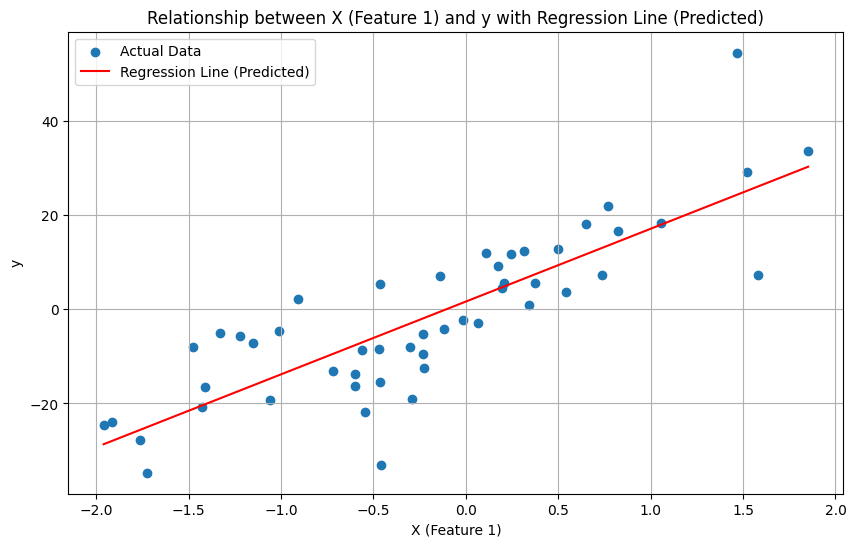

In [25]:
import numpy as np

# 5. 모델을 사용하여 회귀선 시각화
# X의 범위를 생성
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

# 모델로 예측
y_pred = model.predict(X_range)

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], y, label='Actual Data') # 실제 데이터
plt.plot(X_range, y_pred, color='red', label='Regression Line (Predicted)') # 회귀선
plt.title('Relationship between X (Feature 1) and y with Regression Line (Predicted)')
plt.xlabel('X (Feature 1)')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## Load the trained model

### Subtask:
Load the previously saved `regression_model.pkl` using `joblib`.


**Reasoning**:
Load the previously saved model using joblib.



In [27]:
# 2. 모델 로드
# 애플리케이션 시작 시 한 번만 모델을 로드하여 효율성을 높입니다.
try:
    model = joblib.load("regression_model.pkl")
    print("모델 로드 성공!")
except FileNotFoundError:
    raise RuntimeError("모델 파일을 찾을 수 없습니다. 'train_model.py'를 먼저 실행하여 모델을 생성하세요.")


모델 로드 성공!


In [28]:
# 3. 예측을 위한 입력 데이터 스키마 정의
# Pydantic을 사용하여 입력 데이터의 형태와 타입을 정의합니다.
class RegressionInput(BaseModel):
    features: list[float]


In [30]:
import uvicorn
import nest_asyncio
from fastapi import FastAPI
from pyngrok import ngrok
import threading
import time

## Define fastapi application

### Subtask:
Create a FastAPI instance and define a Pydantic model for the input data.


In [ ]:

from google.colab import userdata
your_auth_token_here = userdata.get('ngrok')

# 1. FastAPI 앱 인스턴스 생성
app = FastAPI(
    title="회귀 예측 서비스 API",
    description="Scikit-learn 모델을 사용한 회귀 예측 API"
)


ngrok.set_auth_token(your_auth_token_here)

# 4. 예측 API 엔드포인트 정의
@app.post("/predict")
def predict_regression(data: RegressionInput):
    """
    새로운 데이터를 입력받아 회귀 값을 예측합니다.
    - **data**: 예측에 사용할 1개의 특성(features) 리스트
    """
    # 입력 데이터를 NumPy 배열로 변환
    input_data = np.array(data.features).reshape(1, -1)

    # 모델을 사용하여 예측
    prediction = model.predict(input_data)

    # 예측 결과를 JSON 형태로 반환
    return {"prediction": prediction.tolist()[0]}


# Uvicorn 서버를 비동기적으로 실행하기 위한 설정
nest_asyncio.apply()

def run_server():
    """별도 스레드에서 FastAPI 서버 실행"""
    print("FastAPI 서버를 시작합니다...")
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="info", reload=False)

def setup_ngrok():
    """ngrok 터널 설정"""
    try:
        # ngrok authtoken 설정 (필요한 경우)
        # ngrok.set_auth_token("your_auth_token_here")  # 실제 토큰으로 교체하세요

        print("ngrok 터널을 생성합니다...")

        # ngrok 터널 생성
        public_url = ngrok.connect(8000, "http")

        print("=" * 50)
        print(f"🎉 성공! 외부에서 접근 가능한 URL: {public_url}")
        print("=" * 50)
        print("사용 가능한 엔드포인트:")
        print(f"  • 홈페이지: {public_url}/")
        print(f"  • 헬스체크: {public_url}/health")
        print(f"  • API 문서: {public_url}/docs")
        print(f"  • ReDoc: {public_url}/redoc")
        print("=" * 50)

        return public_url

    except Exception as e:
        print(f"ngrok 설정 중 오류 발생: {e}")
        print("\n해결 방법:")
        print("1. ngrok 계정이 있는지 확인하세요 (https://ngrok.com/)")
        print("2. authtoken을 설정하세요:")
        print("   ngrok.set_auth_token('your_token_here')")
        print("3. 또는 Lightning AI의 포트 포워딩을 사용하세요")
        return None

if __name__ == "__main__":
    # 서버를 별도 스레드에서 시작
    server_thread = threading.Thread(target=run_server, daemon=True)
    server_thread.start()

    # 서버가 시작될 때까지 잠시 대기
    print("서버 시작을 기다리는 중...")
    time.sleep(3)

    # ngrok 터널 설정
    public_url = setup_ngrok()

    if public_url:
        print(f"\n서버가 성공적으로 실행되었습니다!")
        print("서버를 중지하려면 Ctrl+C를 누르세요...")

        try:
            # 서버가 계속 실행되도록 유지
            server_thread.join()
        except KeyboardInterrupt:
            print("\n서버를 종료합니다...")
            ngrok.disconnect(public_url)
            ngrok.kill()
    else:
        print("\nngrok 설정에 실패했습니다. Lightning AI 포트 포워딩을 사용하세요.")
        print("포트 8000이 포워딩되어 있는지 확인하세요.")

FastAPI 서버를 시작합니다...서버 시작을 기다리는 중...



INFO:     Started server process [175]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


ngrok 터널을 생성합니다...
🎉 성공! 외부에서 접근 가능한 URL: NgrokTunnel: "https://b99c2ffed4f2.ngrok-free.app" -> "http://localhost:8000"
사용 가능한 엔드포인트:
  • 홈페이지: NgrokTunnel: "https://b99c2ffed4f2.ngrok-free.app" -> "http://localhost:8000"/
  • 헬스체크: NgrokTunnel: "https://b99c2ffed4f2.ngrok-free.app" -> "http://localhost:8000"/health
  • API 문서: NgrokTunnel: "https://b99c2ffed4f2.ngrok-free.app" -> "http://localhost:8000"/docs
  • ReDoc: NgrokTunnel: "https://b99c2ffed4f2.ngrok-free.app" -> "http://localhost:8000"/redoc

서버가 성공적으로 실행되었습니다!
서버를 중지하려면 Ctrl+C를 누르세요...
INFO:     220.90.109.11:0 - "GET / HTTP/1.1" 404 Not Found


INFO:     220.90.109.11:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     220.90.109.11:0 - "GET /predict HTTP/1.1" 405 Method Not Allowed
INFO:     220.90.109.11:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     220.90.109.11:0 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     220.90.109.11:0 - "POST /predict HTTP/1.1" 200 OK
